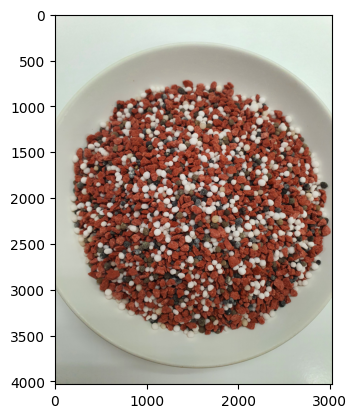

In [2]:
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
import torch
import os
import matplotlib.pyplot as plt

# === Load the image ===
folder_path_1 = "pictures/14-7-35"
folder_path_2 = "pictures/15-7-18"
folder_path_3 = "pictures/15-15-15"
folder_path_4 = "pictures/18-4-5"
images_path_1 = [os.path.join(folder_path_1, f) for f in os.listdir(folder_path_1) if f.endswith('.jpg')]
images_path_2 = [os.path.join(folder_path_2, f) for f in os.listdir(folder_path_2) if f.endswith('.jpg')]
images_path_3 = [os.path.join(folder_path_3, f) for f in os.listdir(folder_path_3) if f.endswith('.jpg')]
images_path_4 = [os.path.join(folder_path_4, f) for f in os.listdir(folder_path_4) if f.endswith('.jpg')]

# Optional: visualize the image (for debugging)
image_bgr = cv2.imread(images_path_1[0])  # Load the first image from the first folder
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()


Image dimensions: 4032x3024


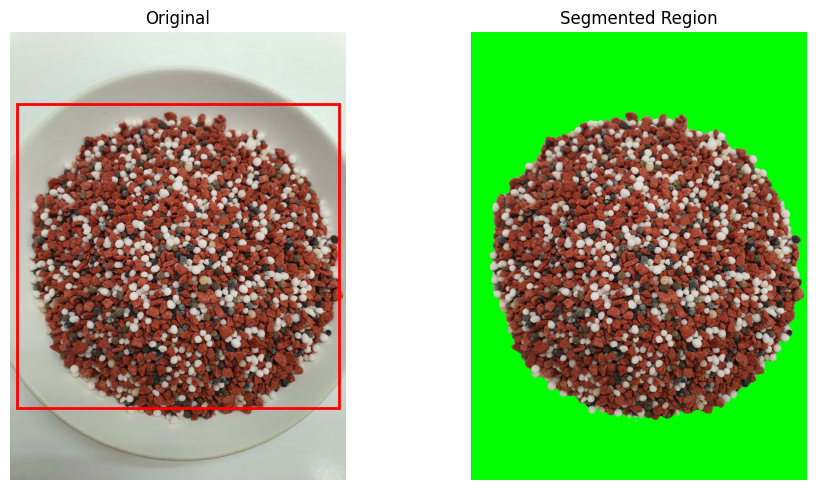

In [3]:
import torch
from segment_anything import sam_model_registry, SamPredictor

img_path = images_path_1[0] # Change to your image path

# === Load the SAM model ===
sam_checkpoint = "sam_vit_b_01ec64.pth"  # Path to your checkpoint file
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# === Load and prepare the image ===
image_bgr = cv2.imread(img_path)  
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(image_rgb)

# === Define a bounding box ===
# Format: [x0, y0, x1, y1] (top-left to bottom-right)
H, W = image_rgb.shape[:2]
print(f"Image dimensions: {H}x{W}")
min_h =  int(H * 0.16)  # Minimum height for the box
max_h = int(H * 0.84)   # Maximum height for the box
min_w = int(W * 0.02)   # Minimum width for the box
max_w = int(W * 0.98)   # Maximum width for the box
input_box = np.array([min_w, min_h, max_w, max_h])  # ← Change as needed

# === Segment using the box ===
masks, scores, logits = predictor.predict(
    box=input_box,
    multimask_output=False  # Only return the most confident mask
)

# === Visualize ===
mask = masks[0]

# Overlay the mask
masked_image = image_rgb.copy()
masked_image[~mask] = [0, 255, 0]  # Set everything else to black

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original")
plt.gca().add_patch(plt.Rectangle(
    (input_box[0], input_box[1]),
    input_box[2] - input_box[0],
    input_box[3] - input_box[1],
    edgecolor='red',
    linewidth=2,
    facecolor='none'
))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.title("Segmented Region")
plt.axis('off')

plt.tight_layout()
plt.show()


Enhancing image...
Start: Showing original image...


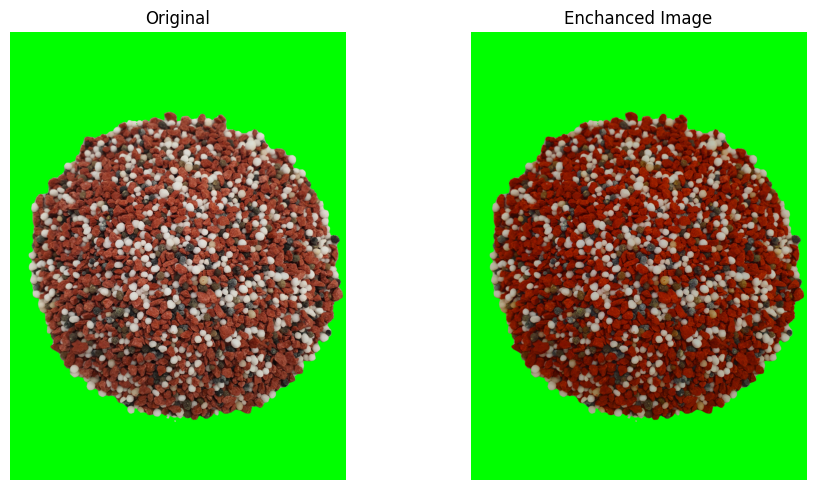

Getting image shape and flattening pixels...
Filtering out pure green pixels...
Running KMeans clustering into 4 clusters...
Preparing valid indices for mapping back...
Processing each cluster to create masks and points...


Clusters:  25%|██▌       | 1/4 [00:02<00:07,  2.50s/it]

Cluster 0: mask created with 2660695 points.


Clusters:  50%|█████     | 2/4 [00:03<00:03,  1.73s/it]

Cluster 1: mask created with 1067744 points.


Clusters:  75%|███████▌  | 3/4 [00:05<00:01,  1.77s/it]

Cluster 2: mask created with 1587413 points.


Clusters: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]

Cluster 3: mask created with 708574 points.
Sorting clusters by total RGB brightness...
All clusters processed. Starting visualization...


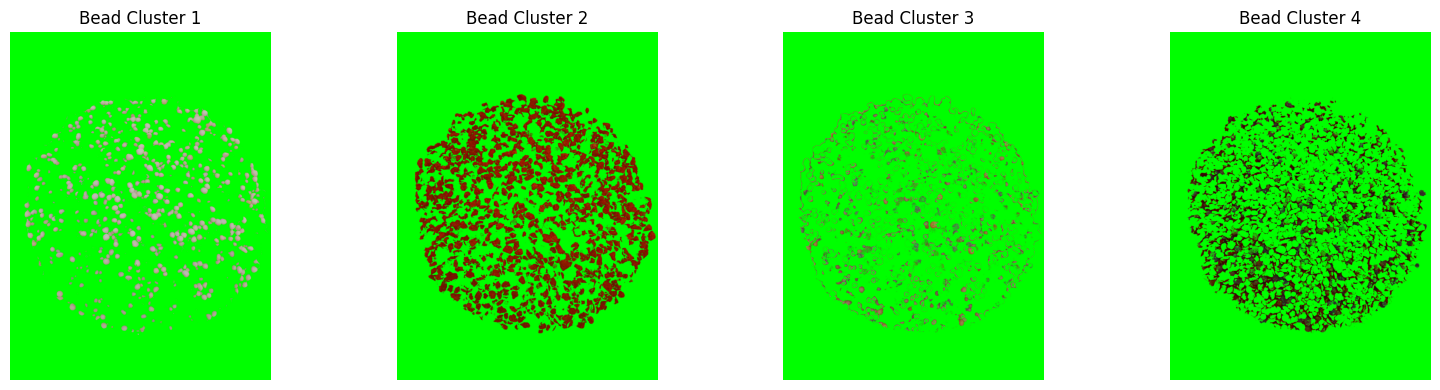

In [9]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm  # Progress bar

# === CONFIG ===
BEAD_MASKS = 4             # Number of clusters
CONTRAST_FACTOR = 0.8       # >1 increases contrast
SATURATION_FACTOR = 2       # >1 increases vividity
BRIGHTNESS_OFFSET = 20      # Offset for brightness adjustment

# === Image enhancement with comprehensive clipping ===
def enhance_image(image, contrast=CONTRAST_FACTOR, saturation=SATURATION_FACTOR, brightness=BRIGHTNESS_OFFSET):
    # Create a mask for pure green pixels (RGB = [0, 255, 0])
    green_mask = np.all(image == [0, 255, 0], axis=-1)

    # Backup green pixels
    green_pixels = image[green_mask]

    # Ensure input is float32 for precise calculations
    img = np.clip(image.astype(np.float32), 0, 255)

    # Apply brightness adjustment with clipping
    img = np.clip(img + brightness, 0, 255)

    # Apply contrast with clipping
    img = np.clip(contrast * img, 0, 255)

    # Convert to uint8 for HSV conversion
    img_uint8 = img.astype(np.uint8)

    # Convert to HSV and apply saturation boost
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[..., 1] = np.clip(hsv[..., 1] * saturation, 0, 255)
    hsv = np.clip(hsv, 0, 255)

    # Convert back to RGB
    enhanced = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)

    # Restore the original green pixels
    enhanced[green_mask] = green_pixels

    return enhanced



# === Grouping points ===
def get_all_grouped_points(label):
    point_coords = []
    group_indices = np.where(labels == label)[0]
    for indice in group_indices:
        original_flat_index = valid_indices[indice]
        y, x = divmod(original_flat_index, W)
        point_coords.append([x, y])
    return np.array(point_coords)

print("Enhancing image...")
enhanced_image = enhance_image(masked_image)

# === Processing starts here ===
print("Start: Showing original image...")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title("Enchanced Image")
plt.axis('off')
plt.tight_layout()
plt.show()

print("Getting image shape and flattening pixels...")
H, W, _ = enhanced_image.shape
pixels = enhanced_image.reshape(-1, 3)

print("Filtering out pure green pixels...")
non_black_indices = np.any(pixels != [0, 255, 0], axis=1)
pixels_non_black = pixels[non_black_indices]

print("Running KMeans clustering into", BEAD_MASKS, "clusters...")
kmeans = KMeans(n_clusters=BEAD_MASKS, random_state=42)
labels = kmeans.fit_predict(pixels_non_black)

print("Preparing valid indices for mapping back...")
valid_indices = np.where(non_black_indices)[0]

all_masks = []
all_point_coords = []

print("Processing each cluster to create masks and points...")
for cluster_label in tqdm(range(BEAD_MASKS), desc="Clusters"):
    mask_flat = np.zeros(H * W, dtype=bool)
    cluster_pixel_indices = valid_indices[labels == cluster_label]
    mask_flat[cluster_pixel_indices] = True
    mask_2d = mask_flat.reshape(H, W)
    point_coords = get_all_grouped_points(cluster_label)
    all_masks.append(mask_2d)
    all_point_coords.append(point_coords)
    print(f"Cluster {cluster_label}: mask created with {len(point_coords)} points.")

print("Sorting clusters by total RGB brightness...")

# Compute total brightness for each mask
brightness_sums = []
for mask in all_masks:
    masked_pixels = enhanced_image[mask]
    brightness = np.sum(masked_pixels)  # Sum of R + G + B
    brightness_sums.append(brightness)

# Get sorted indices from brightest to darkest
sorted_indices = np.argsort(brightness_sums)[::-1]  # Descending order

# Reorder clusters by brightness
all_masks = [all_masks[i] for i in sorted_indices]
all_point_coords = [all_point_coords[i] for i in sorted_indices]

print("All clusters processed. Starting visualization...")

plt.figure(figsize=(16, 4))
for i in range(BEAD_MASKS):
    cluster_img = np.full_like(enhanced_image, fill_value=[0, 255, 0])  # Green background
    mask = all_masks[i]
    cluster_img[mask] = enhanced_image[mask]  # Overlay original colors of cluster

    plt.subplot(1, BEAD_MASKS, i + 1)
    plt.imshow(cluster_img)
    plt.title(f"Bead Cluster {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 61.08it/s]


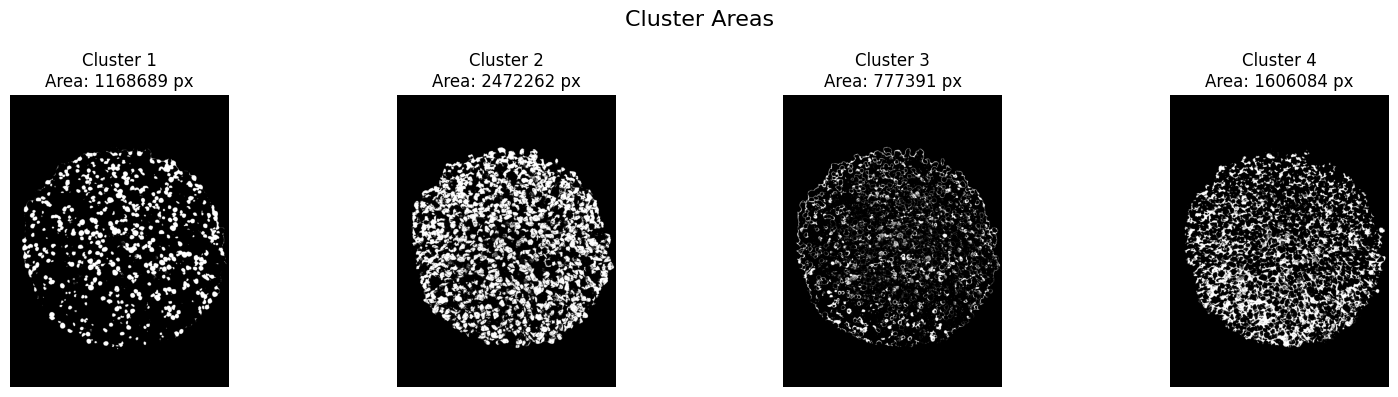


Cluster Area Summary:
Cluster 1: 1168689 pixels
Cluster 2: 2472262 pixels
Cluster 3: 777391 pixels
Cluster 4: 1606084 pixels
Total Cluster Area: 6024426


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# === Assuming `all_masks` is a list of boolean or binary masks (H x W) ===
# all_masks = [...]  # This should already be created before this script runs

# === Compute Cluster Areas ===
cluster_areas = []
for i, mask in enumerate(tqdm(all_masks, desc="Measuring cluster areas")):
    area = np.sum(mask > 0)  # Counts all non-zero (i.e., masked) pixels
    cluster_areas.append(area)

# === Visualization of Mask with Area ===
plt.figure(figsize=(16, 4))
for i, (mask, area) in enumerate(zip(all_masks, cluster_areas)):
    plt.subplot(1, len(all_masks), i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Cluster {i+1}\nArea: {area} px")
    plt.axis('off')
plt.suptitle("Cluster Areas", fontsize=16)
plt.tight_layout()
plt.show()

# === Print Area Summary ===
print("\nCluster Area Summary:")
for i, area in enumerate(cluster_areas):
    print(f"Cluster {i+1}: {area} pixels")

print("Total Cluster Area:", sum(cluster_areas))


In [6]:
print(cluster_areas)

[1168689, 2472262, 777391, 1606084]


In [7]:
def get_npk(cluster_areas):
    
    white_beads = cluster_areas[0]
    red_beads = cluster_areas[1]
    stain_beads = cluster_areas[2]
    black_beads = cluster_areas[3]

    white_composition = {'N': 46, 'P': 0, 'K': 0}
    red_composition   = {'N': 0, 'P': 0, 'K': 60}
    stain_composition = {'N': 21, 'P': 0, 'K': 0}
    black_composition = {'N': 18, 'P': 46, 'K': 0}

    npk_total = {'N': 0, 'P': 0, 'K': 0}

    for key in npk_total:
        npk_total[key] += red_composition[key] * red_beads
        npk_total[key] += white_composition[key] * white_beads
        npk_total[key] += stain_composition[key] * stain_beads
        npk_total[key] += black_composition[key] * black_beads

    total_beads = sum(cluster_areas)
    npk_composition = {key: round(val / total_beads, 2) for key, val in npk_total.items()}
    
    return npk_composition

print(f"NPK Composition: {get_npk(cluster_areas)} in percantage")

NPK Composition: {'N': 16.43, 'P': 12.26, 'K': 24.62} in percantage
